In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

import csv

In [2]:
df = pd.read_csv("yelp_reviews_boba_categories.csv")
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",79nOboO-4_yNuQQ21EAU1A,5,Extremely Nice and clean I go there everyday l...,2021-05-18 22:04:32
1,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",CSBRNusUV3D8t192J-W1yA,3,This experience was a little underwhelming. I...,2021-06-08 02:05:36
2,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",Xc9cAaAlshYfBKOZXg2THA,5,Amazing. Refreshing drinks. There's a shortage...,2021-06-10 19:11:25
3,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",R8kA79smxR1cy22U5ZQ56w,4,At first I questioned why there was another KF...,2021-05-18 19:18:18
4,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.88926,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",bhAB5wo9iLsaExSw4apR4g,4,This is the second Kung Fu tea that has sprung...,2021-07-30 00:24:33


In [3]:
print(len(df.name.unique()))
print(df.state.unique())

119
['NJ' 'NV' 'AZ' 'FL' 'PA' 'IN' 'TN' 'AB' 'CA' 'MO' 'ID' 'LA' 'IL' 'DE']


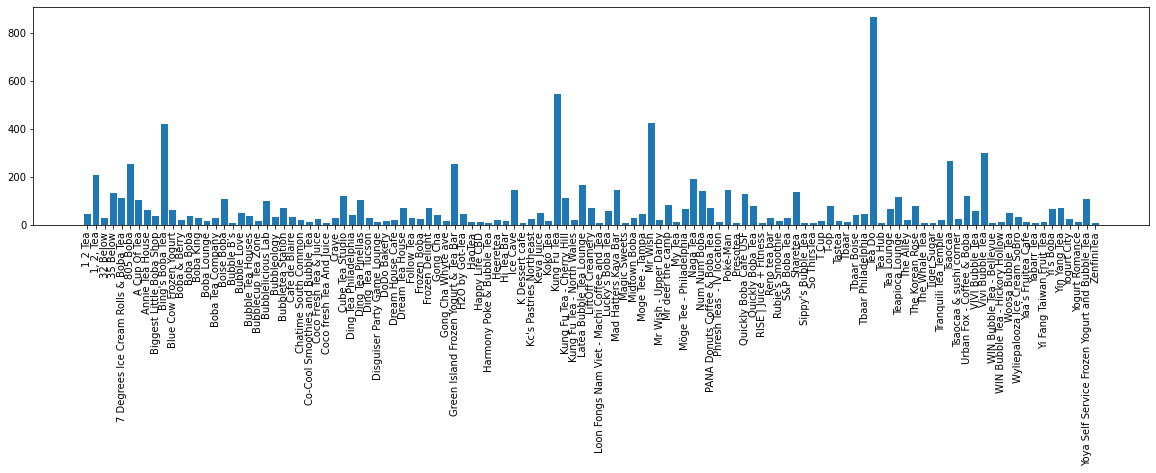

In [4]:
#Total number of reviews for each restaurant
reviewsCount = df.groupby("name")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:ylabel='Review Ratings'>

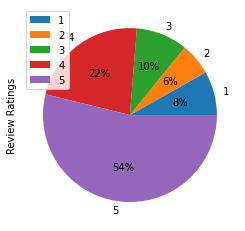

In [5]:
#Distribution of star ratings in dataframe
df.groupby(['review_stars']).count().plot(kind='pie', y='text', ylabel="Review Ratings", autopct='%1.0f%%')

In [6]:
#for i in range(len(df.attributes)):
print(len(df.attributes))
df['attributes'] = df['attributes'].astype(str)
df.head(50)

8581


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",79nOboO-4_yNuQQ21EAU1A,5,Extremely Nice and clean I go there everyday l...,2021-05-18 22:04:32
1,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",CSBRNusUV3D8t192J-W1yA,3,This experience was a little underwhelming. I...,2021-06-08 02:05:36
2,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",Xc9cAaAlshYfBKOZXg2THA,5,Amazing. Refreshing drinks. There's a shortage...,2021-06-10 19:11:25
3,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",R8kA79smxR1cy22U5ZQ56w,4,At first I questioned why there was another KF...,2021-05-18 19:18:18
4,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",bhAB5wo9iLsaExSw4apR4g,4,This is the second Kung Fu tea that has sprung...,2021-07-30 00:24:33
5,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",0MJ5sKX5uq7Ma5hbl4l3BQ,4,Decent..by Brace Rd but only one cashier & was...,2021-10-31 23:30:14
6,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",8B4Q5yZar2XTdfAzu04WUQ,4,"The chicken is super crispy, and if you like a...",2021-08-11 08:05:24
7,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",MfuE21un_E9mPO3UG26PoQ,5,Drinks and food are fantastic. Staff is very f...,2021-06-11 04:19:02
8,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",K1tiI9gz4KRBqgr_A5v5oQ,5,Service and food are great at this location......,2021-06-09 16:07:37
9,i9eMSNpOA8BfHGZrM-9sZg,Kung Fu Tea,1469 Brace Rd,Cherry Hill,NJ,08034,39.889260,-75.015852,4.5,"{'WiFi': ""u'free'"", 'RestaurantsTakeOut': 'True'}","Bubble Tea, Juice Bars & Smoothies, Food, Coff...",tHVFAI0kemjV8Il9UjXBrw,5,This is the new Kung Fu Tea location that just...,2021-12-31 21:55:57


This graph shows the relationship between the cost of Wi-Fi and the star rating given by the user. We can see that since there are more lower ratings when Wi-Fi is not free that there could be a relationship between cost of Wi-Fi and the star rating given by the user.

<AxesSubplot:xlabel='wifi', ylabel='stars'>

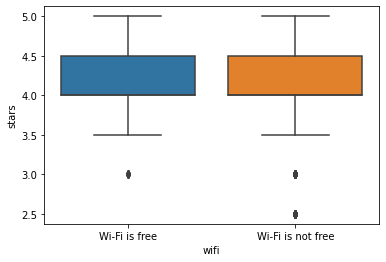

In [7]:
for i in range(len(df.attributes)):
    if df.attributes[i][12:16] == 'free':
        df.loc[i,'wifi'] = "Wi-Fi is free"
    else:
        df.loc[i,'wifi'] = "Wi-Fi is not free"
sns.boxplot(x='wifi', y='stars', data=df)

In [8]:
for i in range(len(df.attributes)):
    if "'RestaurantsTakeOut': 'True'" in df.attributes[i]:
        df.loc[i,'take-out'] = "Yes"
    else:
        df.loc[i,'take-out'] = "No"

This graph shows the relationship between restaurant take-out and the star rating given by the user. We can see that most of the restaurants have take-out and have significantly good ratings given by user. The restaurants that don't have take-out also have similar distribution. Therefore, restaurant take-out does not have much effect on the star rating given by the user. 

<AxesSubplot:ylabel='take-out'>

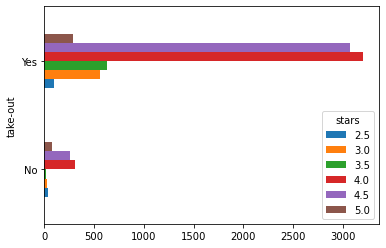

In [9]:
df2 = df.groupby(['take-out','stars']).size()
df2 = df2.unstack()
df2.plot(kind="barh")

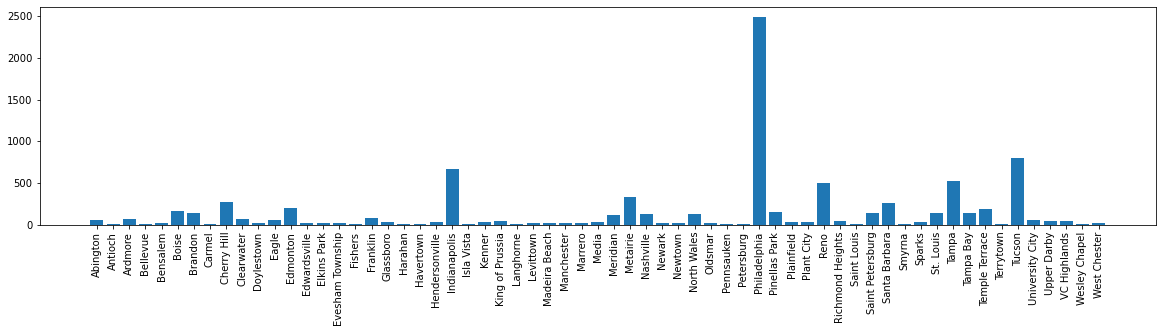

In [10]:
reviewsCount = df.groupby("city")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

The bar graph shows the distribution of places with boba on yelp based on cities in the data set.

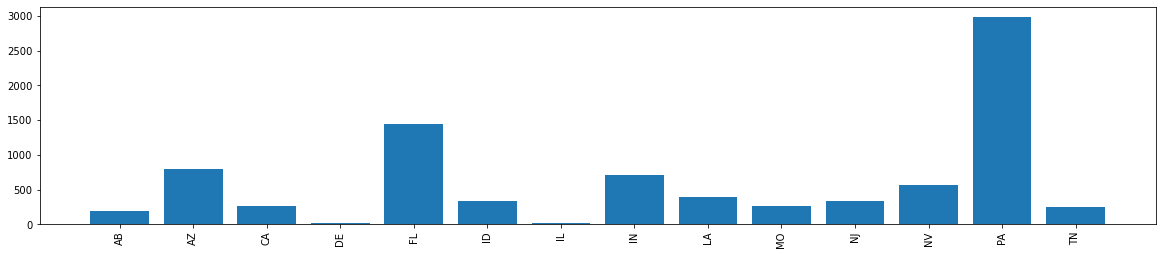

In [11]:
reviewsCount = df.groupby("state")["stars"].count()
plt.figure().set_figwidth(20)
plt.bar(reviewsCount.index,reviewsCount)
plt.xticks(rotation=90)
plt.show()

The bar graph shows the distribution of places with boba on yelp based on states in the data set.

<AxesSubplot:ylabel='Review Stars'>

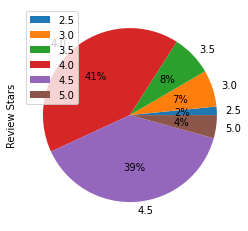

In [12]:
df.groupby(['stars']).count().plot(kind='pie', y='text', ylabel="Review Stars", autopct='%1.0f%%')

These is the distribution of review stars rounded to the half-stars.